In [41]:
import numpy as np
import os
import pandas as pd
import subprocess
import time

import bacco

import matplotlib
from matplotlib import pyplot as plt

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Load SAM data

In [19]:
def ProcessSAMdat_single_redshift_lite(path_to_SAM, Nsubvols, sought_z, fieldswanted, gal_or_halo):
    #NOTE: these ?_colnames are the columns, in order, of the data in the original .dat files. You can give fieldswanted in nearly any order, but the order that the columns will take in the final array will depend on the fields' order in these lists. NOTE: if you care about halo_index, birthhaloID, or roothaloID, redshift will NOT be in the 0th index; update the line below that assumes that!
    g_colnames = ['halo_index', 'birthhaloid', 'roothaloid', 'redshift', 'sat_type',
                  'mhalo', 'm_strip', 'rhalo', 'mstar', 'mbulge', 'mstar_merge', 'v_disk',
                  'sigma_bulge', 'r_disk', 'r_bulge', 'mcold', 'mHI', 'mH2', 'mHII', 'Metal_star',
                  "Metal_cold", 'sfr', 'sfrave20myr', 'sfrave100myr', 'sfrave1gyr',
                  'mass_outflow_rate', 'metal_outflow_rate', 'mBH', 'maccdot', 'maccdot_radio',
                  'tmerge', 'tmajmerge', 'mu_merge', 't_sat', 'r_fric', 'x_position',
                  'y_position', 'z_position', 'vx', 'vy', 'vz']
    h_colnames = ['halo_index', 'halo_id', 'roothaloid', 'orig_halo_ID', 'redshift', 'm_vir', 'c_nfw',
                  'spin', 'm_hot', 'mstar_diffuse', 'mass_ejected', 'mcooldot',
                  'maccdot_pristine', 'maccdot_reaccrete', 'maccdot_metal_reaccrete',
                  'maccdot_metal', 'mdot_eject', 'mdot_metal_eject', 'maccdot_radio',
                  'Metal_hot', 'Metal_ejected', 'snap_num']
    g_header_rows = []
    for i in range(0, len(g_colnames)):
        g_header_rows.append(i)
    h_header_rows = []
    for i in range(0, len(h_colnames)):
        h_header_rows.append(i)

    input_path=path_to_SAM

    if type(fieldswanted) == list:
        print(type(fieldswanted))
    else:
        return "Fieldswanted should be a list with the fields you want as strings!"

    All_halos=np.zeros((1,len(fieldswanted)))
    if gal_or_halo=="gal":
        checknums=0
        for x_i in np.arange(0,Nsubvols,1):
            for x_j in np.arange(0,Nsubvols,1):
                for x_k in np.arange(0,Nsubvols,1):
                    #galprop = pd.read_csv('{}/{}_{}_{}/galprop_0-99.dat'.format(input_path, x_i, x_j, x_k),
                    #                      delimiter=' ', skiprows=g_header_rows, names=g_colnames)
                    # print('galprop read for ',x_i, x_j, x_k,' shape:', galprop.shape)
                    #current_galprops=galprop[fieldswanted[:]].to_numpy()
                    
                    galprop = pd.read_csv('{}/{}_{}_{}/galprop_0-99.dat'.format(input_path, x_i, x_j, x_k),
                                          delimiter=' ', skiprows=g_header_rows, names=g_colnames, 
                                          usecols=fieldswanted)            
                    print(galprop)
                    current_galprops=galprop.to_numpy()
                    print(current_galprops.shape)
                    
                    print('For subvolume ',x_i,x_j,x_k, current_galprops.shape)
                    unique_redshifts=set(current_galprops[:,0]) #update this if redshift will NOT be in the 0th column; see note above
                    unique_redshifts = np.array(sorted(unique_redshifts))
                    # print(unique_redshifts)
                    idx = (np.abs(unique_redshifts - sought_z)).argmin()
                    current_galprops_z=current_galprops[np.where(current_galprops[:,0][:]==unique_redshifts[idx])[0],:]
                    # print(current_galprops_z.shape)
                    checknums=checknums+len(current_galprops_z)
                    All_halos=np.concatenate((All_halos,current_galprops_z))
        print(All_halos.shape, checknums)
        return All_halos
    elif gal_or_halo=="halo":
        checknums2=0
        for x_i in np.arange(0,Nsubvols,1):
            for x_j in np.arange(0,Nsubvols,1):
                for x_k in np.arange(0,Nsubvols,1):
                    haloprop = pd.read_csv('{}/{}_{}_{}/haloprop_0-99.dat'.format(input_path, x_i, x_j, x_k),
                                           delimiter=' ', skiprows=h_header_rows, names=h_colnames)
                    current_haloprops=haloprop[fieldswanted[:]].to_numpy()
                    print('For subvolume ',x_i,x_j,x_k, current_haloprops.shape)
                    unique_redshifts=set(current_haloprops[:,0])
                    unique_redshifts = np.array(sorted(unique_redshifts))
                    idx = (np.abs(unique_redshifts - sought_z)).argmin()
                    current_haloprops_z=current_haloprops[np.where(current_haloprops[:,0][:]==unique_redshifts[idx])[0],:]
                    # print(current_haloprops_z.shape)
                    checknums2=checknums2+len(current_haloprops_z)
                    All_halos=np.concatenate((All_halos,current_haloprops_z))
        print(All_halos.shape, checknums2)
        return All_halos[1:,:]
    else:
        print("gal_or_halo need to be a string, either 'gal' or 'halo', to get galprop or haloprop respectively. Make sure the fields you want are actually reflected!")
        print("Column names of galprop file: ", g_colnames)
        print("Column names of haloprop file: ", h_colnames)
        return All_halos

In [20]:
galprop_fields = ['redshift', 'mstar', 'mhalo', 'x_position', 'y_position', 'z_position']
haloprop_fields = ['redshift','snap_num','spin','m_vir']
redshifts=[0.0]

dir_sams = '/dipc/kstoreyf/CAMELS-SAM'
idx_sam = 0

os.chdir(f'{dir_sams}/LH_{idx_sam}') 
os.system('ls')
totaldirs=(subprocess.check_output('''ls -l sc-sam/ | grep -c ^d''', shell=True,text=True))
totaldirs=np.float64(totaldirs)
Nsubvol=np.int64(totaldirs**(1./3.))

for ZS in np.arange(0,len(redshifts),1):
    Z=redshifts[ZS]
    CurrentSAMdat = ProcessSAMdat_single_redshift_lite(f'{dir_sams}/LH_{idx_sam}/sc-sam', 
                                                       Nsubvol, Z, galprop_fields, 'gal')
    print('CAMELS-SAM simulation LH',idx_sam,' at redshift ', Z, ' has this many galaxies: ', CurrentSAMdat.shape)
    '''This output is a numpy array that can be manipulated in whatever way you like! Columns will be galprop_fields as listed above, each row is a SAM galaxy at redshift Z (or more exactly, whatever Nbody simulation redshift is closest to what you've requested).'''

CosmoAstro_params.txt
sc-sam
<class 'list'>
         redshift    mhalo     mstar  x_position  y_position  z_position
0        3.996000  50.0025  0.207254     13.1203     28.1755     20.9664
1        3.703230  61.3669  0.241536     13.3807     28.1194     20.9623
2        3.490950  71.5940  0.395499     13.5747     28.0928     20.9294
3        3.283020  78.6421  0.693258     13.8124     28.0331     20.9546
4        2.998720  80.2365  0.896575     14.1641     27.9806     20.9449
...           ...      ...       ...         ...         ...         ...
1933272  0.047285  47.7276  0.095421     67.9505     62.1933     63.8437
1933273  0.034950  47.7276  0.096814     67.9370     62.2119     63.8389
1933274  0.023374  47.7276  0.097606     67.9269     62.2213     63.8331
1933275  0.011317  47.7276  0.097935     67.9185     62.2271     63.8295
1933276  0.000000  47.7276  0.097935     67.9050     62.2423     63.8231

[1933277 rows x 6 columns]
(1933277, 6)
For subvolume  0 0 0 (1933277, 6)
     

In [23]:
dat = CurrentSAMdat

In [71]:
dat.shape

(174733, 6)

In [31]:
x_arr = dat[:,galprop_fields.index('x_position')]
y_arr = dat[:,galprop_fields.index('y_position')]
z_arr = dat[:,galprop_fields.index('z_position')]

In [39]:
x_arr.min(), x_arr.max(), z_arr.min(), z_arr.max()

(-1.81249, 149.232, -0.218745, 149.622)

box size: (100 h/Mpc)² 

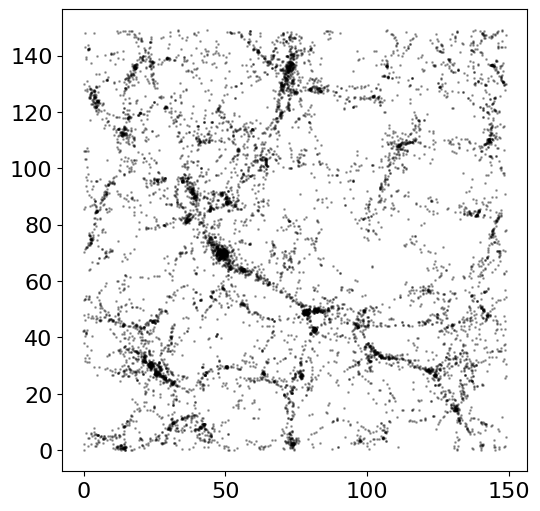

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(x_arr[z_arr < 10], y_arr[z_arr < 10], color='k', s=1, alpha=0.3)


In [51]:
ngrid = 512 #1024 #512 #256 #128 #256 #1400
nmean=0.01
h=0.6711
BoxSize=100/h
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : False}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


In [56]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2023-12-19 16:50:10,960 bacco.cosmo :    initialization took 0.000 secs


In [68]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':False,
                  'kmin':0.01,
                  'kmax':1.0,
                  'nbins':50,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'compute_power2d':False}

In [69]:
pos_arr = np.array([x_arr, y_arr, z_arr])
pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)

2023-12-19 16:57:28,310 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2023-12-19 16:57:28,311 bacco.statistics :  setting the grid 512 False
2023-12-19 16:57:28,311 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2023-12-19 16:57:28,313 bacco.statistics : starting deposit 1
2023-12-19 16:57:28,314 bacco.statistics :  mesh done in 0.00229 s
2023-12-19 16:57:28,314 bacco.statistics :  Starting the power spectrum calculation
2023-12-19 16:57:28,963 bacco.statistics :  done compute.power
2023-12-19 16:57:28,965 bacco.statistics :  power done in 0.655 s


Text(0, 0.5, '$P(k)$')

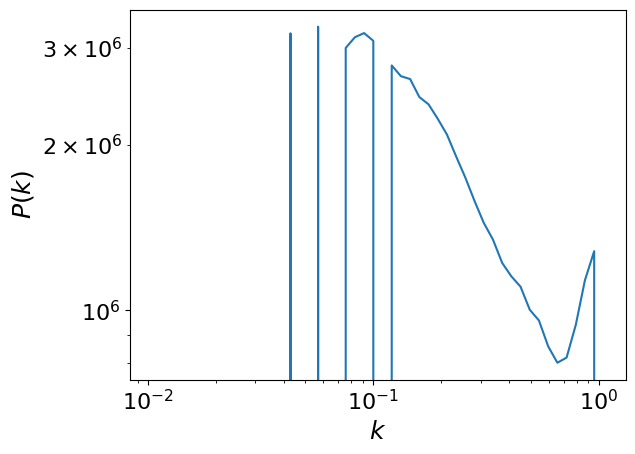

In [72]:
plt.plot(pk['k'], pk['pk'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')